# Performance Evaluation

## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd

/content


In [3]:
%cd "drive/MyDrive/22-23/DS 301 Advanced Data Science/DS 301 Final Project"

/content/drive/.shortcut-targets-by-id/1L_EikC2ryU5sSu8xLqkBA2WHnRs7BMt-/DS 301 Final Project


In [4]:
!pwd

/content/drive/.shortcut-targets-by-id/1L_EikC2ryU5sSu8xLqkBA2WHnRs7BMt-/DS 301 Final Project


In [5]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Import

In [6]:
# importing the libraries

import pandas as pd
import numpy as np
import copy
import time

# for visualization

import plotly.express as px
import matplotlib.pyplot as plt

In [7]:
# models

import statsmodels.api as sm
import sklearn.model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import xgboost as xgb

In [8]:
# dict used to convert state to abbrev

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}


## Reading data/helper functions

In [9]:
# Reading the training data

data = pd.read_csv('state_data_2019_processed_training.csv')

states = data.sitecode.unique()

In [10]:
# Creating the training/testing sets

state_data_t = []

state_data_test = []

seed = 100

for state in states:

    state_data = data[data.sitecode == state]
    X_s = state_data.iloc[:,:-1]
    y_s = state_data.iloc[:,-1]
    X_tr, X_val, y_tr, y_val = sklearn.model_selection.train_test_split(
        X_s, y_s, test_size=0.4, random_state=seed, stratify=y_s)
    X_val, X_te, y_val, y_te = sklearn.model_selection.train_test_split(
        X_val, y_val, test_size=0.5, random_state=seed, stratify=y_val)
    state_data_t.append([X_tr, X_val, y_tr, y_val])
    state_data_test.append((X_te, y_te))

X_train, X_val, y_train, y_val = state_data_t[0]

for i in range(1, len(state_data_t)):
    X_t,X_v,y_t,y_v = state_data_t[i]
    X_train = pd.concat([X_train, X_t])
    y_train = pd.concat([y_train, y_t])
    X_val = pd.concat([X_val, X_v])
    y_val = pd.concat([y_val, y_v])

In [11]:
# functions for visualizing the results

def map(model, race = 'all', exclude = None, data = state_data_t):

    auc_all = pd.DataFrame({'state': [us_state_to_abbrev[s] for s in states], 'auc': np.zeros(len(states))})

    for i, state in enumerate(states):
        _, X_test, _, y_test = data[i]
        if(race != 'all'):
            if(race == 'black'):
                index = X_test['race4_Black or African American'] == 1
            if(race == 'hispanic'):
                index = X_test['race4_Hispanic/Latino'] == 1
            X_test = X_test.loc[index]
            y_test = y_test.loc[index]
        if(exclude != None):
            X_test = X_test.drop(columns = exclude)
        y_pred = model.predict_proba(X_test.iloc[:,4:])
        fpr, tpr,_ = metrics.roc_curve(y_test, y_pred[:,1])
        auc = metrics.auc(fpr,tpr)
        auc_all.iloc[i,1] = auc

    fig = px.choropleth(auc_all,
                        locations='state', 
                        locationmode="USA-states", 
                        scope="usa",
                        color='auc',
                        color_continuous_scale="Viridis_r",
                        range_color = [0.6,1] 
                        )
    return fig, auc_all

def count_race(data = state_data_t):
    race = pd.DataFrame({
        'others': np.zeros(len(states)),
        'black': np.zeros(len(states)),
        'hispanic': np.zeros(len(states)),
        'white': np.zeros(len(states)),
        'missing': np.zeros(len(states))
    }, index = states)
    for i, state in enumerate(states):
        _, X_test, _, _ = data[i]
        race.iloc[i,0] = X_test['race4_All other races'].sum()
        race.iloc[i,1] = X_test['race4_Black or African American'].sum()
        race.iloc[i,2] = X_test['race4_Hispanic/Latino'].sum()
        race.iloc[i,3] = X_test['race4_White'].sum()
        race.iloc[i,4] = X_test['race4_All other races'].count() - \
            race.iloc[i,0] - race.iloc[i,1] -race.iloc[i,2] -race.iloc[i,3]
    
    return race

## Building Models

#### Logisitc Model

In [12]:
# Logistic Model

logistic_model = LogisticRegression(
    penalty='l2',
    max_iter=200
)
start = time.time()
logistic_model.fit(X_train.iloc[:,4:], y_train)
print(time.time() - start)

12.801203489303589


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Random Forest

In [13]:
# Random Forest Model

rf_model = RandomForestClassifier(
    max_depth=30,
    max_features=40, 
    min_samples_leaf=20,
    min_samples_split=10,
    n_estimators=200,
    random_state = seed, 
    criterion = 'gini'
)
start = time.time()
rf_model.fit(X_train.iloc[:,4:], y_train)
print(time.time() - start)

80.24308705329895


#### XGBoost

In [17]:
# XGBoost Model

config =  {'objective': 'binary:logistic',
  'tree_method': 'hist',
  'eval_metric': ['auc'],
  'max_depth': 9,
  'min_child_weight': 1,
  'colsample_bytree': 0.626608 ,
  'eta': 0.0757007,
  'reg_lambda': 4.87132,
  'reg_alpha': 2.21019,
  'n_estimators': 200,
  'seed': 0}

train_set = xgb.DMatrix(X_train.iloc[:,4:].values,y_train.values)
val_set = xgb.DMatrix(X_val.iloc[:,4:].values,y_val.values)
results = {}
start = time.time()
xgb_model = xgb.train(
    config,
    train_set,
    num_boost_round = 50,
    evals = [(val_set, 'eval')],
    evals_result = results,
    early_stopping_rounds=2,
)
print(time.time() - start)

[0]	eval-auc:0.769628
Will train until eval-auc hasn't improved in 2 rounds.
[1]	eval-auc:0.833519
[2]	eval-auc:0.840038
[3]	eval-auc:0.844017
[4]	eval-auc:0.846314
[5]	eval-auc:0.846906
[6]	eval-auc:0.848079
[7]	eval-auc:0.850158
[8]	eval-auc:0.851161
[9]	eval-auc:0.851679
[10]	eval-auc:0.852108
[11]	eval-auc:0.852872
[12]	eval-auc:0.853416
[13]	eval-auc:0.854177
[14]	eval-auc:0.854509
[15]	eval-auc:0.855392
[16]	eval-auc:0.855593
[17]	eval-auc:0.855977
[18]	eval-auc:0.855891
[19]	eval-auc:0.856588
[20]	eval-auc:0.856657
[21]	eval-auc:0.856856
[22]	eval-auc:0.857152
[23]	eval-auc:0.857652
[24]	eval-auc:0.859036
[25]	eval-auc:0.859129
[26]	eval-auc:0.859353
[27]	eval-auc:0.859498
[28]	eval-auc:0.86
[29]	eval-auc:0.860362
[30]	eval-auc:0.860592
[31]	eval-auc:0.860628
[32]	eval-auc:0.860946
[33]	eval-auc:0.861251
[34]	eval-auc:0.861523
[35]	eval-auc:0.861915
[36]	eval-auc:0.862251
[37]	eval-auc:0.862395
[38]	eval-auc:0.863004
[39]	eval-auc:0.863113
[40]	eval-auc:0.863019
[41]	eval-auc:0.

#### NN

In [18]:
# Neural network

import tensorflow as tf
import math

from keras.models import Sequential
from keras.layers import Dense
from keras import initializers
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

config ={'units': 10, 'layers': 4, 'activation': 'ReLU'}
n_units = config['units']
n_layers = config['layers']
activation = config['activation']
if(activation == 'tanh' or activation == 'sigmoid'):
    initializer = 'glorot_uniform'
else:
    initializer = 'he_normal'

model = Sequential()

model.add(Dense(units = n_units, 
                input_dim=X_train.iloc[:,4:].shape[1], 
                activation= activation,
                kernel_initializer= initializer, 
                name='h1'))

for i in range(2, n_layers + 1):
    model.add(Dense(units= n_units, 
                    activation= activation,
                    kernel_initializer= initializer,  
                    name='h{}'.format(i)))
    
model.add(Dense(units=1, activation='sigmoid', kernel_initializer=initializer, name='o'))

model.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.01), 
    metrics=['AUC'])

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 3.0
    return 0.01 * math.pow(drop_rate, math.floor(epoch/epochs_drop))

In [19]:
start = time.time()
model.fit(
    X_train.iloc[:,4:].values,
    y_train.values,
    batch_size=128,
    epochs=50,
    verbose=1,
    validation_data=(X_val.iloc[:,4:].values, y_val.values),
    callbacks=[
        LearningRateScheduler(
            lr_step_decay, verbose=0
        ),
        EarlyStopping(
            monitor='val_auc', 
            patience=5
        )
    ])
print(time.time() - start)

Epoch 1/50
592/592 [==============================] - 8s 9ms/step - loss: 0.2387 - auc: 0.8304 - val_loss: 0.2307 - val_auc: 0.8536 - lr: 0.0100
Epoch 2/50
592/592 [==============================] - 2s 4ms/step - loss: 0.2258 - auc: 0.8554 - val_loss: 0.2357 - val_auc: 0.8585 - lr: 0.0100
Epoch 3/50
592/592 [==============================] - 2s 4ms/step - loss: 0.2231 - auc: 0.8602 - val_loss: 0.2243 - val_auc: 0.8610 - lr: 0.0100
Epoch 4/50
592/592 [==============================] - 2s 4ms/step - loss: 0.2197 - auc: 0.8655 - val_loss: 0.2280 - val_auc: 0.8599 - lr: 0.0050
Epoch 5/50
592/592 [==============================] - 2s 4ms/step - loss: 0.2205 - auc: 0.8633 - val_loss: 0.2274 - val_auc: 0.8610 - lr: 0.0050
Epoch 6/50
592/592 [==============================] - 2s 4ms/step - loss: 0.2187 - auc: 0.8663 - val_loss: 0.2243 - val_auc: 0.8618 - lr: 0.0050
Epoch 7/50
592/592 [==============================] - 2s 3ms/step - loss: 0.2168 - auc: 0.8692 - val_loss: 0.2254 - val_auc: 0.861

### AutoML

In [20]:
!pip install requests
!pip install tabulate
!pip install future

!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 177.5 MB 46 kB/s 
  Created wheel for h2o: filename=h2o-3.38.0.3-py2.py3-none-any.whl size=177541401 sha256=78ffff880133c5a6bc9b26ec52be88b71eb5f453f6cd400834788f9ae0b24fff
  Stored in directory: /root/.cache/pip/wheels/16/f8/f4/69e1ff6a0d1cb61bdbc0d9888ee8437a1acf1eb1c6ffb8be20
Successfully built h2o


In [21]:
import h2o

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpru0xjyq8
  JVM stdout: /tmp/tmpru0xjyq8/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpru0xjyq8/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,08 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_unknownUser_k324db
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [22]:
!pwd

/content/drive/.shortcut-targets-by-id/1L_EikC2ryU5sSu8xLqkBA2WHnRs7BMt-/DS 301 Final Project


In [23]:
automl_model = h2o.load_model(path = "/content/drive/.shortcut-targets-by-id/1L_EikC2ryU5sSu8xLqkBA2WHnRs7BMt-/DS 301 Final Project/GBM_5_AutoML_2_20221218_193524")

## Different race

### Data

In [24]:
X_test, y_test = state_data_test[0]

for i in range(1,len(state_data_test)):
  X_t,  y_t = state_data_test[i]
  X_test = pd.concat([X_test, X_t])
  y_test = pd.concat([y_test, y_t])

In [25]:
#X_test, y_test = X_val, y_val

### All/Baseline

In [26]:
X_all = X_test.iloc[:,4:]

In [27]:
y_all_pred_log = logistic_model.predict_proba(X_all)[:,1]

y_all_pred_rf = rf_model.predict_proba(X_all)[:,1]

y_all_pred_xgb = xgb_model.predict(xgb.DMatrix(X_all.values))

y_all_pred_nn = model.predict(X_all)

y_all_pred_auto = automl_model.predict(h2o.H2OFrame(X_all))['p1'].as_data_frame()


790/790 [==============================] - 3s 4ms/step
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


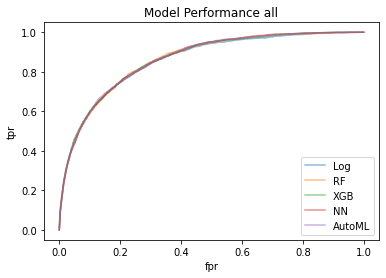

[0.8584650802305585, 0.8634126536514177, 0.8630954731450802, 0.8621379916376862, 0.8639410802234194]


In [42]:
auc_list = []

plt.title('Model Performance all')
plt.xlabel('fpr')
plt.ylabel('tpr')

for y_pred in [y_all_pred_log, y_all_pred_rf, y_all_pred_xgb, y_all_pred_nn, y_all_pred_auto]:

  fpr,tpr, _ = metrics.roc_curve(y_test, y_pred)
  auc_list.append(metrics.roc_auc_score(y_test, y_pred))

  plt.plot(fpr,tpr, alpha = 0.5)

plt.legend(['Log','RF','XGB','NN','AutoML'])
plt.show()

print(auc_list)

### White

In [29]:
index = X_test['race7_White'] == 1

X_white = X_test.loc[index]
X_white = X_white.iloc[:,4:]
y_white = y_test.loc[index]

In [30]:
y_white_pred_log = logistic_model.predict_proba(X_white)[:,1]

y_white_pred_rf = rf_model.predict_proba(X_white)[:,1]

y_white_pred_xgb = xgb_model.predict(xgb.DMatrix(X_white.values))

y_white_pred_nn = model.predict(X_white)

y_white_pred_auto = automl_model.predict(h2o.H2OFrame(X_white))['p1'].as_data_frame()

439/439 [==============================] - 2s 4ms/step
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


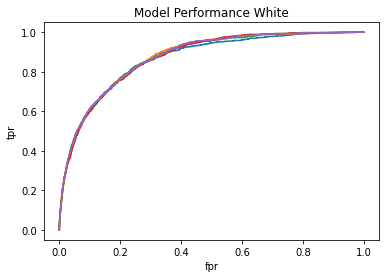

[0.8650120523354309, 0.8726491528742343, 0.8727207117504001, 0.8708909236780934, 0.872990120845705]


In [31]:
auc_list = []

plt.title('Model Performance White')
plt.xlabel('fpr')
plt.ylabel('tpr')

for y_pred in [y_white_pred_log, y_white_pred_rf, y_white_pred_xgb, y_white_pred_nn, y_white_pred_auto]:

  fpr,tpr, _ = metrics.roc_curve(y_white, y_pred)
  auc_list.append(metrics.roc_auc_score(y_white, y_pred))

  plt.plot(fpr,tpr)

plt.show()

print(auc_list)

### Black

In [32]:
index = X_test['race7_Black or African American'] == 1

X_black = X_test.loc[index]
X_black = X_black.iloc[:,4:]
y_black = y_test.loc[index]

In [33]:
y_black_pred_log = logistic_model.predict_proba(X_black)[:,1]

y_black_pred_rf = rf_model.predict_proba(X_black)[:,1]

y_black_pred_xgb = xgb_model.predict(xgb.DMatrix(X_black.values))

y_black_pred_nn = model.predict(X_black)

y_black_pred_auto = automl_model.predict(h2o.H2OFrame(X_black))['p1'].as_data_frame()

72/72 [==============================] - 0s 2ms/step
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


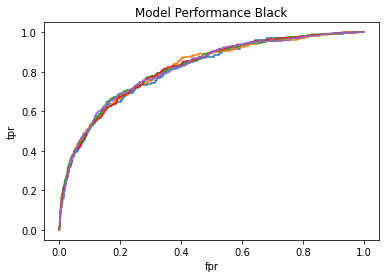

[0.8116319846949378, 0.8165693785409701, 0.8194983264381555, 0.8173147103424232, 0.81792522982495]


In [34]:
auc_list = []

plt.title('Model Performance Black')
plt.xlabel('fpr')
plt.ylabel('tpr')

for y_pred in [y_black_pred_log, y_black_pred_rf, y_black_pred_xgb, y_black_pred_nn,y_black_pred_auto]:

  fpr,tpr, _ = metrics.roc_curve(y_black, y_pred)
  auc_list.append(metrics.roc_auc_score(y_black, y_pred))

  plt.plot(fpr,tpr)

plt.show()

print(auc_list)



### Hispanic

In [35]:
index = X_test['race7_Hispanic/Latino'] == 1

X_hispanic = X_test.loc[index]
X_hispanic = X_hispanic.iloc[:,4:]
y_hispanic = y_test.loc[index]

In [36]:
y_hispanic_pred_log = logistic_model.predict_proba(X_hispanic)[:,1]

y_hispanic_pred_rf = rf_model.predict_proba(X_hispanic)[:,1]

y_hispanic_pred_xgb = xgb_model.predict(xgb.DMatrix(X_hispanic.values))

y_hispanic_pred_nn = model.predict(X_hispanic)

y_hispanic_pred_auto = automl_model.predict(h2o.H2OFrame(X_hispanic))['p1'].as_data_frame()

156/156 [==============================] - 0s 1ms/step
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


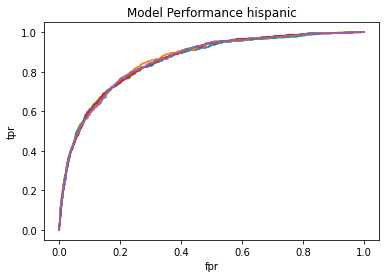

[0.8566120715802245, 0.8603314590575738, 0.8573645038613191, 0.8589117534977407, 0.8589537497180808]


In [37]:
auc_list = []

plt.title('Model Performance hispanic')
plt.xlabel('fpr')
plt.ylabel('tpr')

for y_pred in [y_hispanic_pred_log, y_hispanic_pred_rf, y_hispanic_pred_xgb, y_hispanic_pred_nn,y_hispanic_pred_auto]:

  fpr,tpr, _ = metrics.roc_curve(y_hispanic, y_pred)
  auc_list.append(metrics.roc_auc_score(y_hispanic, y_pred))

  plt.plot(fpr,tpr)

plt.show()

print(auc_list)



### Asian

In [38]:
index = X_test['race7_Asian'] == 1

X_Asian = X_test.loc[index]
X_Asian = X_Asian.iloc[:,4:]
y_Asian = y_test.loc[index]

In [39]:
y_Asian_pred_log = logistic_model.predict_proba(X_Asian)[:,1]

y_Asian_pred_rf = rf_model.predict_proba(X_Asian)[:,1]

y_Asian_pred_xgb = xgb_model.predict(xgb.DMatrix(X_Asian.values))

y_Asian_pred_nn = model.predict(X_Asian)

y_Asian_pred_auto = automl_model.predict(h2o.H2OFrame(X_Asian))['p1'].as_data_frame()

38/38 [==============================] - 0s 2ms/step
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


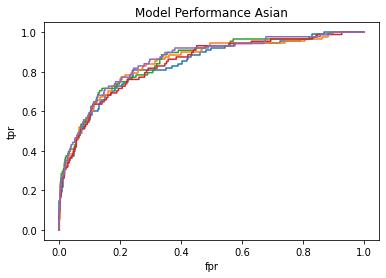

[0.8361902073082197, 0.8486428168105187, 0.8547884568847302, 0.8410200048398807, 0.859003186254739]


In [40]:
auc_list = []

plt.title('Model Performance Asian')
plt.xlabel('fpr')
plt.ylabel('tpr')

for y_pred in [y_Asian_pred_log, y_Asian_pred_rf, y_Asian_pred_xgb, y_Asian_pred_nn,y_Asian_pred_auto]:

  fpr,tpr, _ = metrics.roc_curve(y_Asian, y_pred)
  auc_list.append(metrics.roc_auc_score(y_Asian, y_pred))

  plt.plot(fpr,tpr)

plt.show()

print(auc_list)



In [43]:
len(X_white)

14018

In [44]:
len(X_black)

2292

In [45]:
len(X_hispanic)

4981

In [46]:
len(X_test)

25256